In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
import re
import glob
import pickle
import numpy
import tqdm
import corner
from scipy.misc import logsumexp
from scipy import interpolate
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.actionAngle import actionAngleTorus
from galpy.orbit import Orbit
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_conversion, bovy_coords, save_pickles
import seaborn as sns
import MWPotential2014Likelihood
import pal5_util
import mcmc_pal5
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
ro, vo= _REFR0, _REFV0
%pylab inline
from matplotlib import cm
import copy
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Exploration of the Milky Way's dark halo shape using the Palomar 5 stream

## The data

In [3]:
pos_radec, rvel_ra= pal5_util.pal5_data()

## Some convenience functions

In [4]:
width_trailing= pal5_util.width_trailing

In [5]:
def plot_data_add_labels(radeconly=False,rvonly=False,color=sns.color_palette()[2]):
    if not radeconly and not rvonly: subplot(1,2,1)
    if not rvonly:
        xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
        ylabel(r'$\mathrm{Dec}\,(\mathrm{degree})$')
        xlim(250.,220.)
        ylim(-5.,9.)
        bovy_plot._add_ticks()
        errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
                 ls='none',marker='o',color=color)
    if radeconly: return None
    if not rvonly: subplot(1,2,2)
    xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
    ylabel(r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$')
    xlim(250.,220.)
    ylim(-80.,0.)
    bovy_plot._add_ticks()
    errorbar(rvel_ra[rvel_ra[:,0] > 230.5,0],rvel_ra[rvel_ra[:,0] > 230.5,1],
             yerr=rvel_ra[rvel_ra[:,0] > 230.5,2],
             ls='none',marker='o',color=color)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025,0.78])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



## A fiducial model

The fiducial model assumes a spherical halo, with the best-fit parameters from fitting to the MWPotential2014 data

In [6]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
ro,vo= _REFR0,_REFV0
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.0,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=pot,b=0.8)
sigv= 0.2

In [18]:
sdf_trailing= streamdf(sigv/vo,progenitor=prog,
                       pot=pot,aA=aAI,
                       leading=False,nTrackChunks=11,
                       tdisrupt=10./bovy_conversion.time_in_Gyr(vo,ro),
                       ro=ro,vo=vo,R0=ro,
                       vsun=[-11.1,vo+24.,7.25],
                       custom_transform=pal5_util._TPAL5)
sdf_leading= streamdf(sigv/vo,progenitor=prog,
                      pot=pot,aA=aAI,
                      leading=True,nTrackChunks=11,
                      tdisrupt=10./bovy_conversion.time_in_Gyr(vo,ro),
                      ro=ro,vo=vo,R0=ro,
                      vsun=[-11.1,vo+24.,7.25],
                      custom_transform=pal5_util._TPAL5)

In [19]:
threshold= 0.3
print "Angular length: %f deg (leading,trailing)=(%f,%f) deg" % \
    (sdf_leading.length(ang=True,coord='customra',threshold=threshold)\
    +sdf_trailing.length(ang=True,coord='customra',threshold=threshold),
     sdf_leading.length(ang=True,coord='customra',threshold=threshold),
     sdf_trailing.length(ang=True,coord='customra',threshold=threshold))
print "Angular width (FWHM): %f arcmin" % (width_trailing(sdf_trailing))

Angular length: 840.286323 deg (leading,trailing)=(790.162099,50.124224) deg
Angular width (FWHM): 20.800555 arcmin


In [20]:
trackRADec_trailing=\
  bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)
trackRADec_leading=\
  bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
                          sdf_leading._interpolatedObsTrackLB[:,1],
                          degree=True)
lb_sample_trailing= sdf_trailing.sample(n=10000,lb=True)
lb_sample_leading= sdf_leading.sample(n=10000,lb=True)
radec_sample_trailing= bovy_coords.lb_to_radec(lb_sample_trailing[0],
                                               lb_sample_trailing[1],
                                               degree=True)
radec_sample_leading= bovy_coords.lb_to_radec(lb_sample_leading[0],
                                              lb_sample_leading[1],
                                              degree=True)

<Container object of 3 artists>

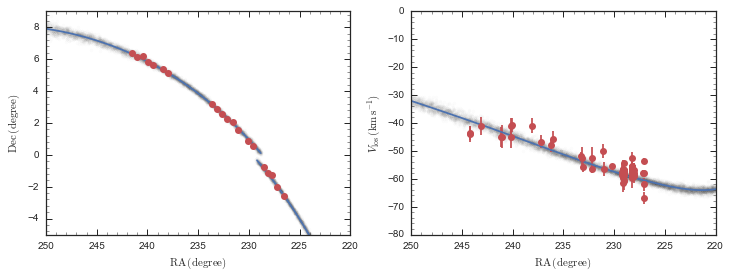

In [22]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    trackRADec_trailing[:,1],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-5.,9.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$\mathrm{Dec}\,(\mathrm{degree})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    trackRADec_leading[:,1],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],radec_sample_trailing[:,1],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],radec_sample_leading[:,1],'k.',
     alpha=0.01,zorder=0)
errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])
subplot(1,2,2)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    sdf_trailing._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-80.,0.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    sdf_leading._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],lb_sample_trailing[3],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],lb_sample_leading[3],'k.',
     alpha=0.01,zorder=0)
errorbar(rvel_ra[:,0],rvel_ra[:,1],yerr=rvel_ra[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])

## The orbit of Pal 5 in different flattened and triaxial potentials

In [12]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    print IOError("Need to calculate best-fit potentials for different c in MWPotential2014-varyc.ipynb first")
bf_params= numpy.array(bf_params)
bf_params= bf_params[cs <= 3.]
cs= cs[cs <= 3.]

In [13]:
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
for bp,c in zip(bf_params,cs):
    pot= MWPotential2014Likelihood.setup_potential(bp,c,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

Vary $c$ along the best-fit line:

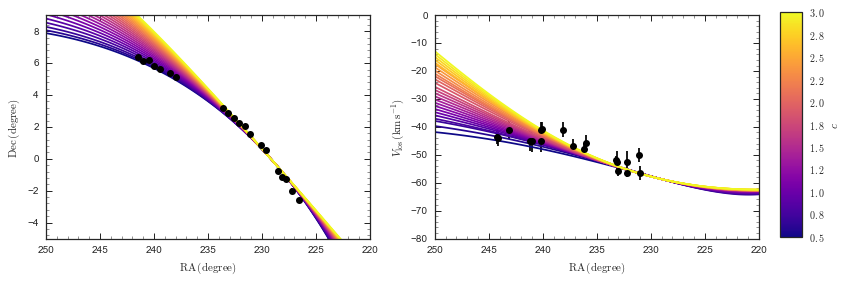

In [14]:
figsize(12,4)
cmap= cm.plasma
for c,orb,orbf in zip(cs,progs,progfs):
    tc= cmap((c-0.5)/2.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,3.,r'$c$',save_figures=False)

Vary $b$ for $c=1$ (pa=0):

In [15]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
bs= numpy.arange(0.5,2.1,0.1)
for b in bs:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo,b=b)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

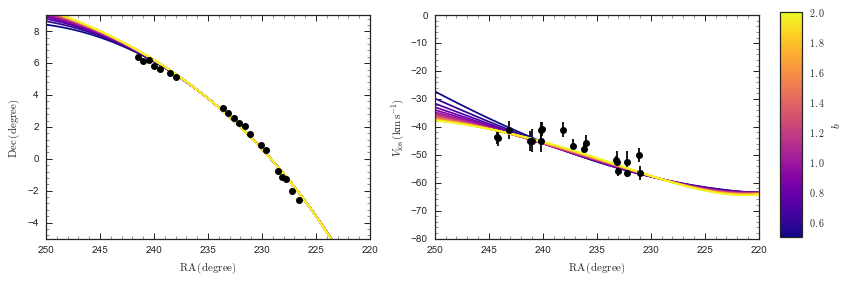

In [16]:
figsize(12,4)
cmap= cm.plasma
for b,orb,orbf in zip(bs,progs,progfs):
    tc= cmap((b-0.5)/1.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,2.,r'$b$',save_figures=False)

Vary $b$ for $c=1$ (pa=45 degree):

In [17]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
bs= numpy.arange(0.5,2.1,0.1)
for b in bs:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo,b=b,pa=numpy.pi/4.)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

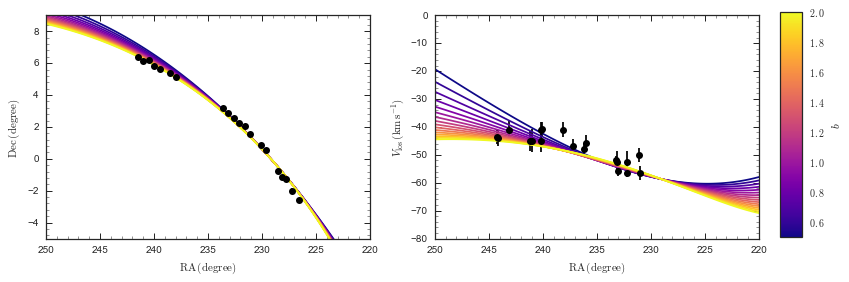

In [18]:
figsize(12,4)
cmap= cm.plasma
for b,orb,orbf in zip(bs,progs,progfs):
    tc= cmap((b-0.5)/1.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,2.,r'$b$',save_figures=False)

Vary the distance:

In [19]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
ds= numpy.linspace(22.5,24.5,101)
for d in ds:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,d,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,d,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

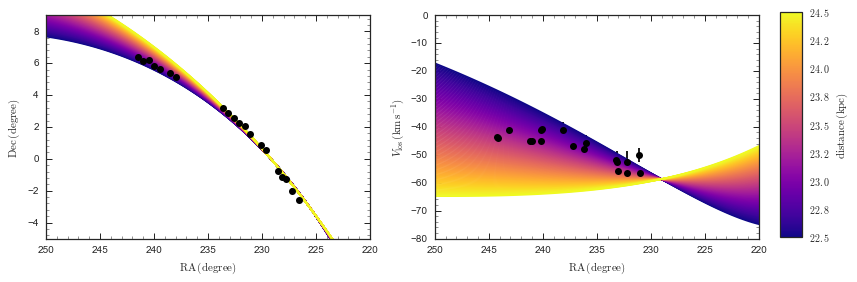

In [20]:
figsize(12,4)
cmap= cm.plasma
for d,orb,orbf in zip(ds,progs,progfs):
    tc= cmap((d-numpy.amin(ds))/(numpy.amax(ds)-numpy.amin(ds)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(ds),numpy.amax(ds),r'$\mathrm{distance}\,(\mathrm{kpc})$',save_figures=False)

Vary the proper motion parallel to the stream:

In [21]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,2.5,101)
pms= numpy.linspace(-0.3,0.3,101)
for pm in pms:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257+2.257/2.296*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257+2.257/2.296*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

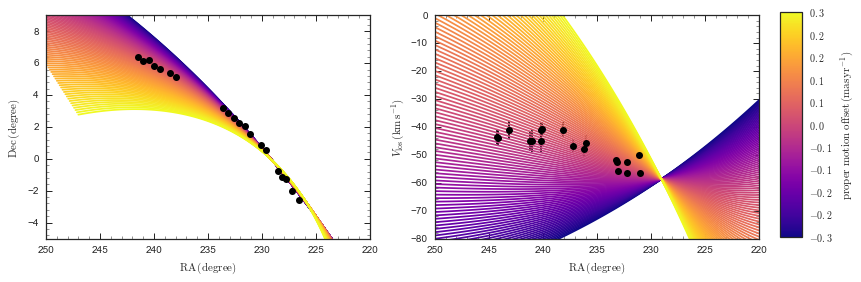

In [22]:
figsize(12,4)
cmap= cm.plasma
for pm,orb,orbf in zip(pms,progs,progfs):
    tc= cmap((pm-numpy.amin(pms))/(numpy.amax(pms)-numpy.amin(pms)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(pms),numpy.amax(pms),r'$\mathrm{proper\ motion\ offset}\,(\mathrm{mas\,yr}^{-1})$',
             save_figures=False)

Vary the proper motion perpendicular to the stream:

In [23]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,2.5,101)
pms= numpy.linspace(-0.3,0.3,101)
for pm in pms:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257-2.296/2.257*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257-2.296/2.257*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

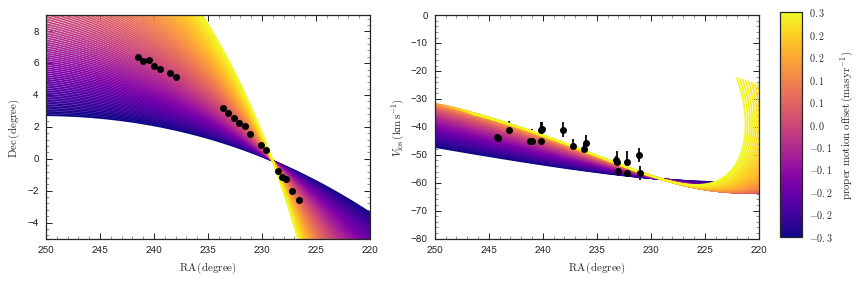

In [24]:
figsize(12,4)
cmap= cm.plasma
for pm,orb,orbf in zip(pms,progs,progfs):
    tc= cmap((pm-numpy.amin(pms))/(numpy.amax(pms)-numpy.amin(pms)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(pms),numpy.amax(pms),r'$\mathrm{proper\ motion\ offset}\,(\mathrm{mas\,yr}^{-1})$',
             save_figures=False)

## How does the track, width, and length of the Pal 5 stream vary with the potential and the uncertain phase-space location of the Pal 5 cluster?

We compute the stream structure for a fiducial set of parameters, to get a sense of where the track lies and how the width and length vary

In [25]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

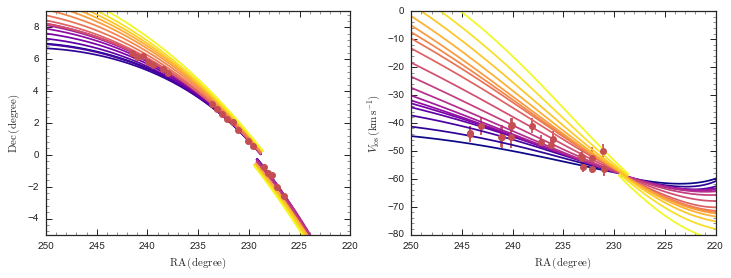

In [26]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()

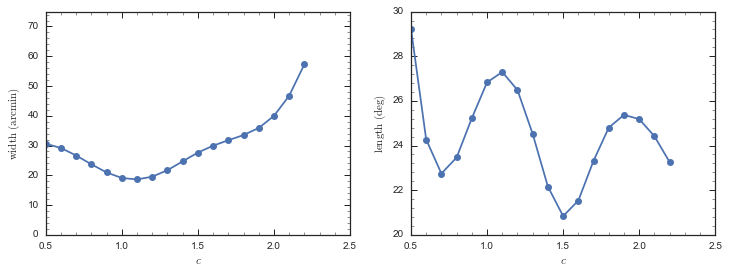

In [27]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

Let's now try to make all streams 18' wide and 25 degree long:

In [28]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-constwl.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc_constwl= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    interpcs= numpy.array([0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    ipw= interpolate.InterpolatedUnivariateSpline(cs,pal5varyc[4],k=3)
    ipl= interpolate.InterpolatedUnivariateSpline(cs,pal5varyc[5],k=3)
    sigv=0.4*18./ipw(interpcs)
    td=5.*25./ipl(interpcs)/(sigv/0.4)
    td[td > 14.]= 14. # don't allow older than 14 Gyr
    print sigv
    print td
    pal5varyc_constwl= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                                 interpcs=interpcs,
                                                 sigv=sigv,td=td,useTM=False)
    save_pickles(savefilename,cs,pal5varyc_constwl)

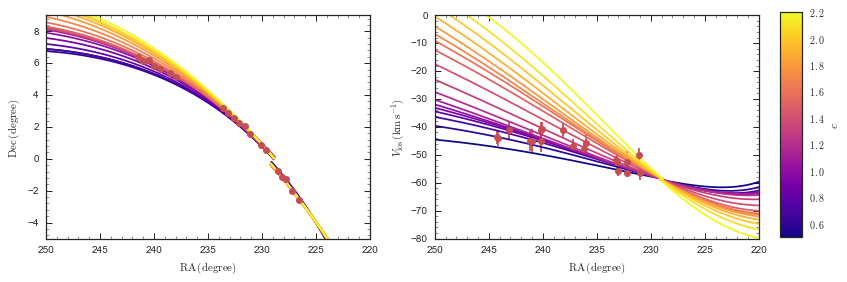

In [29]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_constwl[0][ii,:,0],
                        pal5varyc_constwl[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[1][ii,:,0],
                        pal5varyc_constwl[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_constwl[2][ii,:,0],
                        pal5varyc_constwl[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[3][ii,:,0],
                        pal5varyc_constwl[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

Directly compare a subset ($c=0.5$ to $2.1$ in $0.2$ increments):

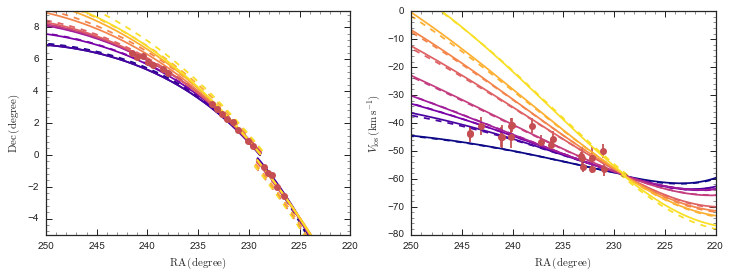

In [30]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs[::2]):
    ii*= 2
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_constwl[0][ii,:,0],
                        pal5varyc_constwl[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[1][ii,:,0],
                        pal5varyc_constwl[1][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_constwl[2][ii,:,0],
                        pal5varyc_constwl[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[3][ii,:,0],
                        pal5varyc_constwl[3][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
plot_data_add_labels()

The differences are small, especially around $c\approx1$. The width and length of the stream, pre-correction in green:

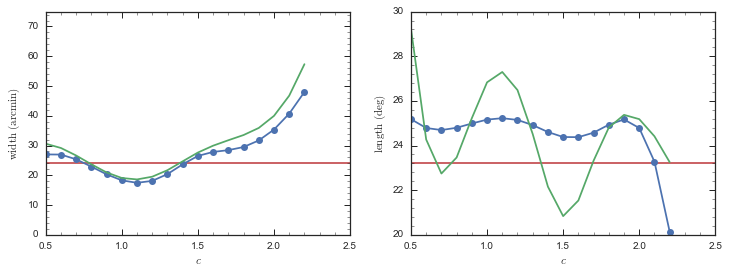

In [31]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc_constwl[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
bovy_plot.bovy_plot(cs,pal5varyc[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    overplot=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc_constwl[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
bovy_plot.bovy_plot(cs,pal5varyc[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    overplot=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

It appears that the increase in the stream age undoes the effect of making the stream colder on the width of the stream. This raises the question whether it is at all possible to have a long, cold stream in these $c\neq1$ potentials.

A test with double the number of track points, to see whether that matters. It does not:

In [32]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-ntc16.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=16,nTrackChunks=16,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

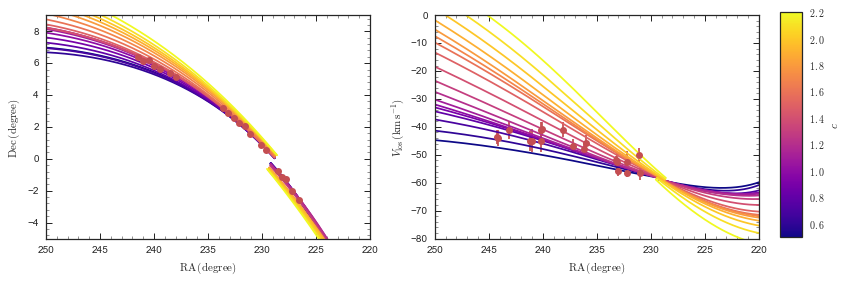

In [33]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

Let's take a look at the grid-points themselves, to see whether the same trend shows for them. They do:

In [34]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-singlec.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.array([0.5,0.75,1.,1.25,1.55,1.75,2.,2.25])
    trackRADec_trailing_out= numpy.empty((len(cs),1001,2))
    trackRADec_leading_out= numpy.empty((len(cs),1001,2))
    trackRAVlos_trailing_out= numpy.empty((len(cs),1001,2))
    trackRAVlos_leading_out= numpy.empty((len(cs),1001,2))
    width_out= numpy.empty(len(cs))
    length_out= numpy.empty(len(cs))
    for ii,c in enumerate(cs):
        tpal5varyc= pal5_util.predict_pal5obs(p_b15,c,multi=8,singlec=True)
        trackRADec_trailing_out[ii]= tpal5varyc[0]
        trackRADec_leading_out[ii]= tpal5varyc[1]
        trackRAVlos_trailing_out[ii]= tpal5varyc[2]
        trackRAVlos_leading_out[ii]= tpal5varyc[3]
        width_out[ii]= tpal5varyc[4]
        length_out[ii]= tpal5varyc[5]
    pal5varyc= (trackRADec_trailing_out,trackRADec_leading_out,
                trackRAVlos_trailing_out,trackRAVlos_leading_out,
                width_out,length_out)
    save_pickles(savefilename,cs,pal5varyc)

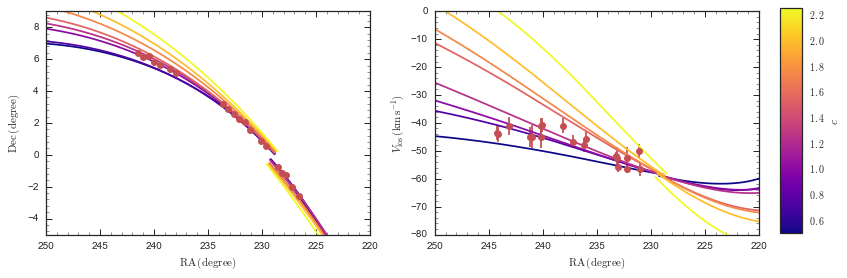

In [35]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

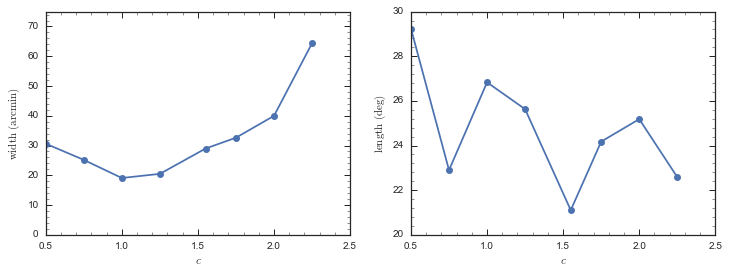

In [36]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

What happens when we use a denser interpolation grid?

In [37]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-densergrid.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.05)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.5,1.6,1.7,1.8,1.9,2.,2.1,2.2])
    save_pickles(savefilename,cs,pal5varyc)

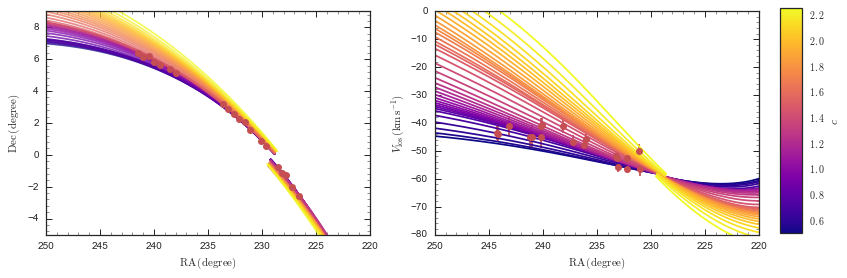

In [38]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True,alpha=0.75)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True,alpha=0.75)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

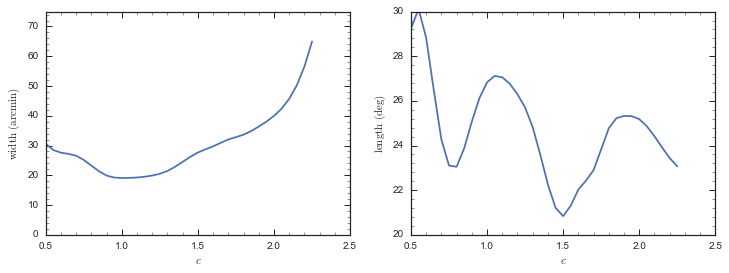

In [39]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

Does this change for different potential parameters?

In [40]:
p_b15= [0.65,0.3,-1.14,-3.44,1.1,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-shortscale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

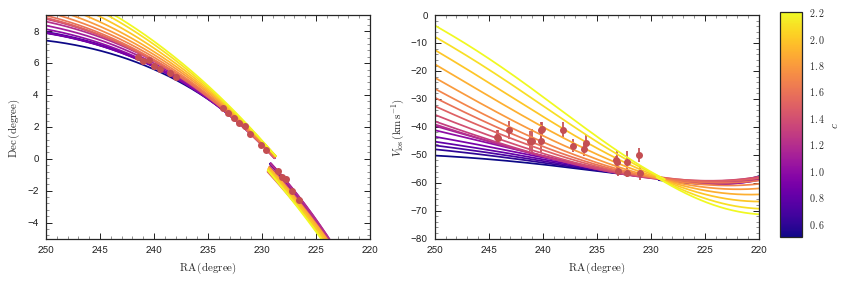

In [41]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c < .95 or (c > 1.05 and c < 1.25): continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

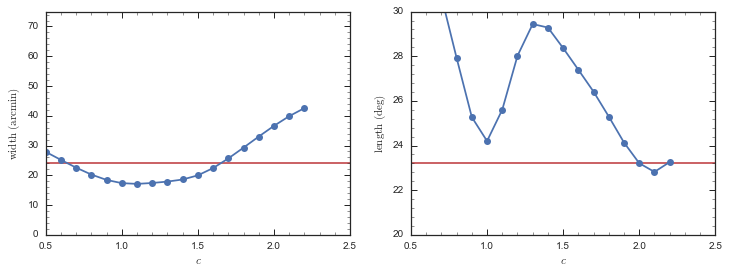

In [42]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

Another different potential:

In [43]:
p_b15= [0.65,0.3,-0.8,-3.13,0.2,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-longscale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

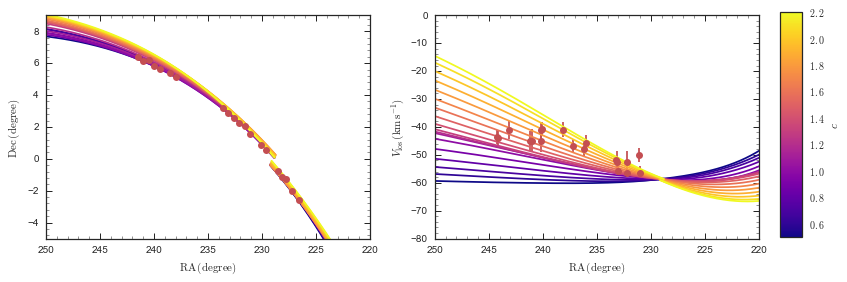

In [44]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if numpy.fabs(c-1.2) > 0.01 and numpy.fabs(c-2.) > 0.01: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

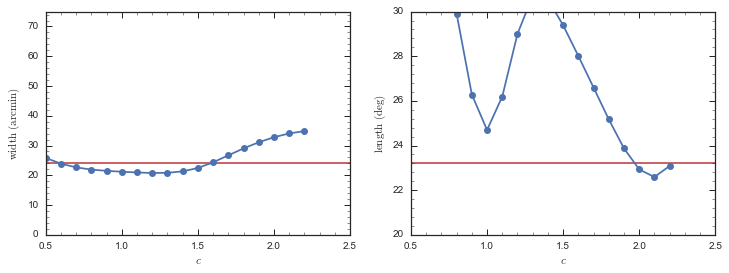

In [45]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

Another one to test:

In [46]:
p_b15= [0.45,0.45,-1.,-3.2,0.9,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-somescale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

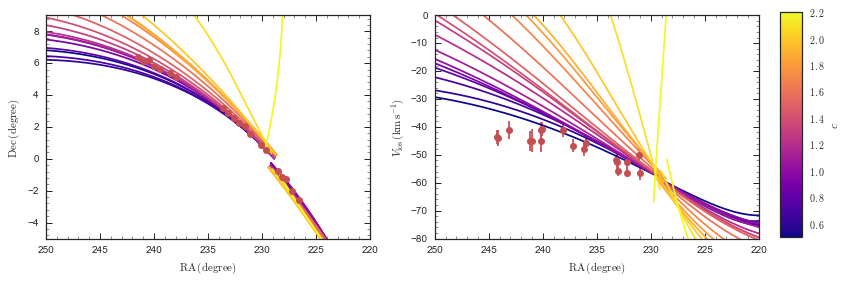

In [47]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

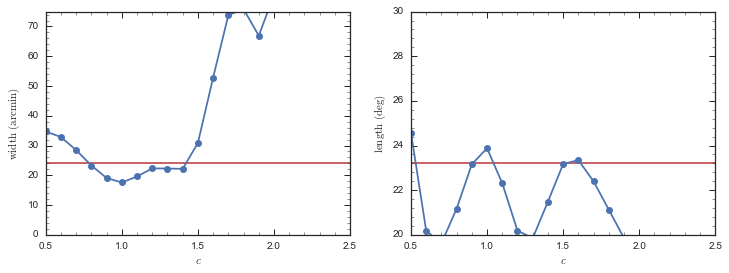

In [48]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

## Different distances

In [49]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-D22p5.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.array([0.5,0.75,1.,1.25,1.5,1.75,2.])
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,dist=22.5,interpk=1,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.6,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

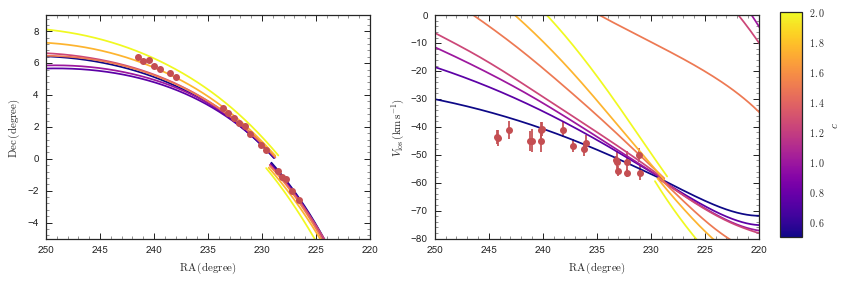

In [50]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c < 1.2 or c > 1.3: continue
#    if c < 2.: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

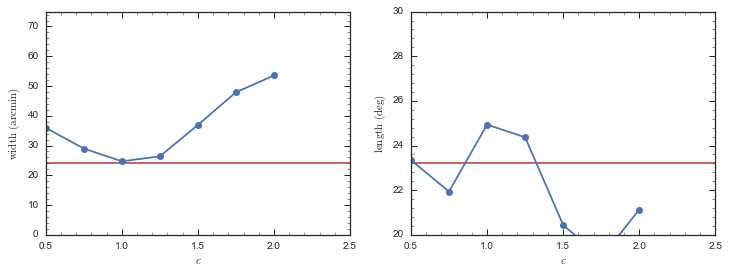

In [51]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

In [52]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-D24p5.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.8,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,dist=24.5,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

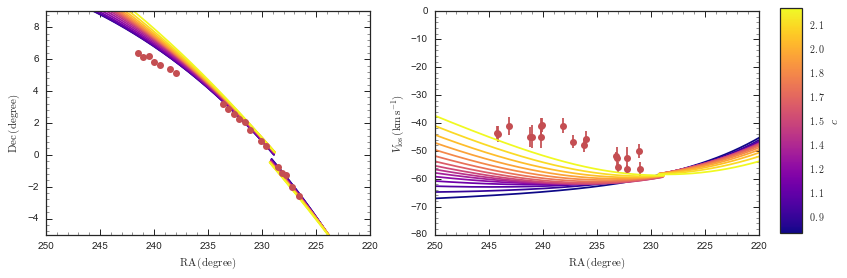

In [53]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c > 1.: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

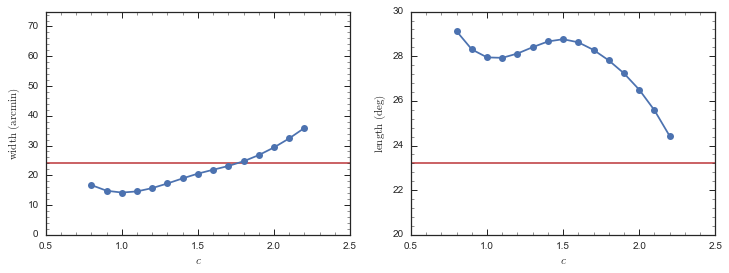

In [54]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

## A very dens grid of models

In [55]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-like.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc_like= pickle.load(savefile)
else:
    # First just compute the interpolation points, to adjust the width and length
    interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25]
    pal5varyc= pal5_util.predict_pal5obs(p_b15,interpcs,multi=8,interpcs=interpcs)
    cs= numpy.arange(0.5,2.21,0.01)
    sigv=0.4*18./pal5varyc[4]
    td=5.*25./pal5varyc[5]/(sigv/0.4)
    td[td > 14.]= 14. # don't allow older than 14 Gyr
    print sigv
    print td
    pal5varyc_like= pal5_util.predict_pal5obs(p_b15,cs,multi=8,interpcs=pal5varyc[6],
                                              sigv=sigv,td=td)
    save_pickles(savefilename,cs,pal5varyc_like)

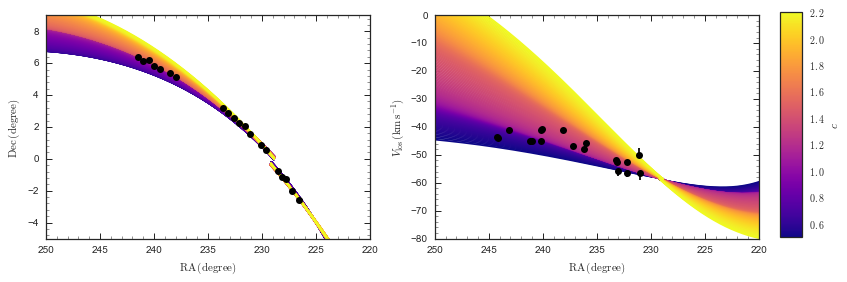

In [56]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_like[0][ii,:,0],
                        pal5varyc_like[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_like[1][ii,:,0],
                        pal5varyc_like[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_like[2][ii,:,0],
                        pal5varyc_like[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_like[3][ii,:,0],
                        pal5varyc_like[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

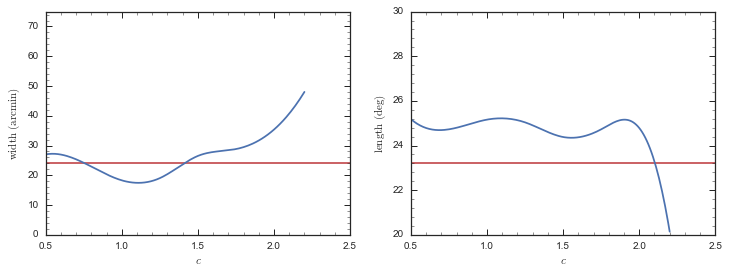

In [57]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc_like[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc_like[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

# MCMC results

## The convergence of different walkers for each potential:

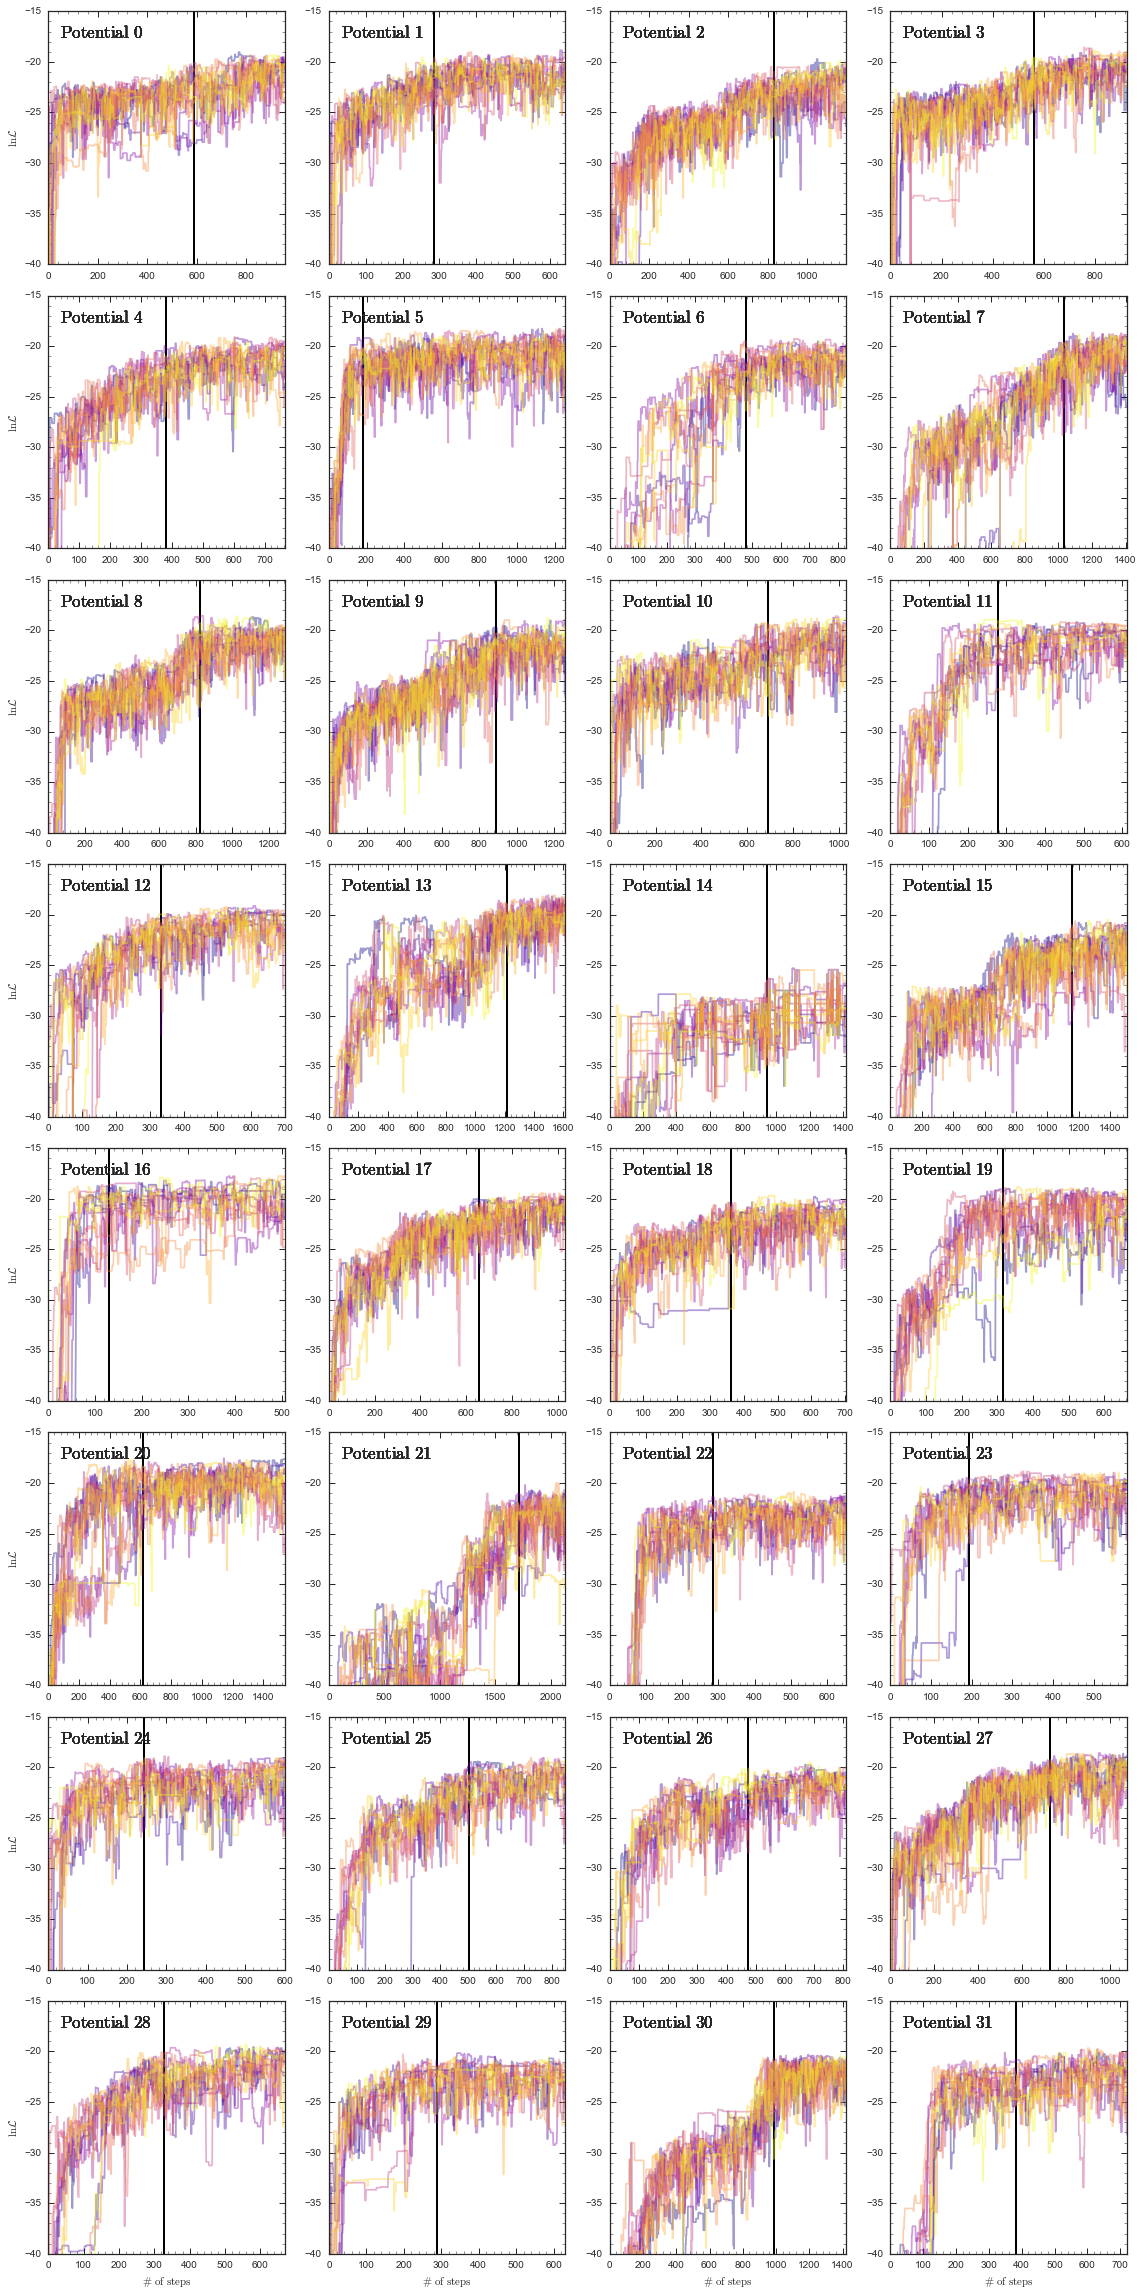

In [11]:
npot= 32
nwalkers= 12
nrow= int(numpy.ceil(npot/4.))
figsize(16,nrow*4)
cmap= cm.plasma
from __builtin__ import range
for en,ii in enumerate(range(npot)):
    fn= '../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii
    data= numpy.loadtxt(fn,comments='#',delimiter=',')
    subplot(nrow,4,en+1)
    sdata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    for jj in range(nwalkers):
        if ii%4 == 0 and jj == 0:
            ylabel=r'$\ln \mathcal{L}$'
        else:
            ylabel= None
        if ii//4 == nrow-1 and jj == 0:
            xlabel= r'$\#\ \mathrm{of\ steps}$'
        else:
            xlabel= None
        bovy_plot.bovy_plot(range(len(sdata[:,jj])),sdata[:,jj],
                            '-',alpha=0.4,
                            color=cmap(jj/11.),
                            yrange=[-40.,-15.],
                            ylabel=ylabel,xlabel=xlabel,
                            gcf=True)
        bovy_plot.bovy_text(r'$\mathrm{Potential}\ %i$' % ii,size=17.,
                            top_left=True)
    nburn= determine_nburn(fn)//nwalkers
    pyplot.axvline(nburn,lw=2.,zorder=1,color='k')
tight_layout()

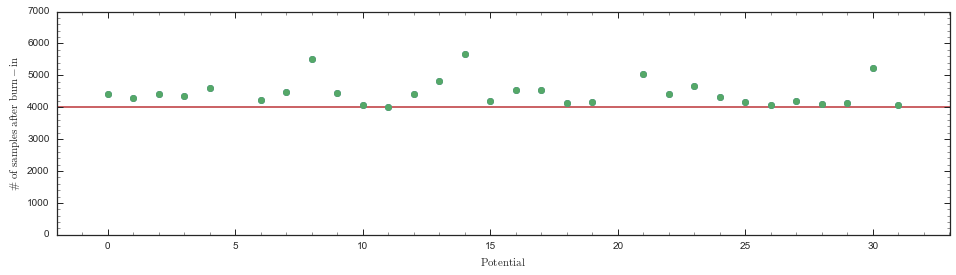

In [13]:
figsize(16,4)
try:
    old_nsamps= copy.deepcopy(nsamps)
except NameError:
    nsamps= numpy.zeros(npot)
    old_nsamps= numpy.zeros(npot)
for en,ii in enumerate(range(npot)):
    fn= '../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii
    nsamps[en]= determine_nburn(fn,return_nsamples=True)
bovy_plot.bovy_plot(numpy.arange(npot),nsamps,
                   'o',
                    xrange=[-2.,33.],
                    yrange=[0.,7000.],
                    xlabel=r'$\mathrm{Potential}$',
                    ylabel=r'$\#\ \mathrm{of\ samples\ after\ burn-in}$')
bovy_plot.bovy_plot(numpy.arange(npot),old_nsamps,
                   'o',overplot=True)
axhline(4000.,color=sns.color_palette()[2],zorder=0)

In [14]:
for ii in range(32):
    if determine_nburn('../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii,return_nsamples=True) > 4000: continue
    print ii, determine_nburn('../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii,return_nsamples=True), \
        determine_nburn_old('../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii,return_nsamples=True), nsamps[ii]

## Resulting PDFs

In [5]:
# Read the necessary data for MWPotential2014Likelihood
reload(MWPotential2014Likelihood)
#First read the surface densities
surffile= '../mwpot14data/bovyrix13kzdata.csv'
if not surffile is None and os.path.exists(surffile):
    surf= numpy.loadtxt(surffile,delimiter=',')
    surfrs= surf[:,2]
    kzs= surf[:,6]
    kzerrs= surf[:,7]*1000.
# Then the terminal velocities
cl_glon, cl_vterm, cl_corr= MWPotential2014Likelihood.readClemens(dsinl=0.125)
mc_glon, mc_vterm, mc_corr= MWPotential2014Likelihood.readMcClureGriffiths(dsinl=0.125)
termdata= (cl_glon,cl_vterm,cl_corr,
           mc_glon,mc_vterm,mc_corr)
def evi_harmonic(x):
    # Simple harmonic mean estimator of the evidence, bad!!
    return 1./numpy.mean(numpy.exp(-x[:,-1]))
def evi_laplace(x):
    # Laplace estimator of the evidence
    mindx= numpy.argmax(x[:,-1])
    C= numpy.cov(x[:,:6],rowvar=False)
    return numpy.exp(x[mindx,-1])/numpy.sqrt(numpy.linalg.det(C))
def determine_nburn_old(filename='../pal5_mcmc/mwpot14-fitsigma-0.dat',
                    threshold=0.1,skip=50,
                    return_nsamples=False):
    """Function to detemrine an appropriate nburn for a given chain"""
    # Load the data
    data= numpy.loadtxt(filename,comments='#',delimiter=',')
    lndata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    # Perform a running diff wrt skip less
    diff= (lndata-numpy.roll(lndata,skip,axis=0))
    diff[:skip]= -100. # Make sure it's not within the first hundred
    maxln= numpy.nanmax(lndata)
    try:
        if return_nsamples:
            return len(data)-numpy.arange(len(lndata))[\
                   (numpy.fabs(numpy.median(diff,axis=1)) < threshold)\
                       *((maxln-numpy.nanmax(lndata,axis=1)) < 1.25)][0]*nwalkers
        else:
            return numpy.arange(len(lndata))[\
                   (numpy.fabs(numpy.median(diff,axis=1)) < threshold)\
                       *((maxln-numpy.nanmax(lndata,axis=1)) < 1.25)][0]*nwalkers
    except IndexError:
        if return_nsamples: return 100.
        else: return numpy.prod(lndata.shape)-100
def determine_nburn(filename='../pal5_mcmc/mwpot14-fitsigma-0.dat',
                    threshold=0.1,skip=50,
                    return_nsamples=False):
    """Function to detemrine an appropriate nburn for a given chain"""
    # Load the data
    data= numpy.loadtxt(filename,comments='#',delimiter=',')
    lndata= numpy.reshape(data[:,-1],(len(data[:,5])//nwalkers,nwalkers))
    # Perform a running diff wrt skip less
    diff= (lndata-numpy.roll(lndata,skip,axis=0))
    diff[:skip]= -100. # Make sure it's not within the first hundred
    maxln= numpy.nanmax(lndata)
    try:
        indx= (numpy.fabs(numpy.median(diff,axis=1)) < threshold)\
                       *((maxln-numpy.nanmax(lndata,axis=1)) < 1.25)
        if maxln > -22.5:
            indx*= numpy.std(lndata,axis=1) < 3.
        if return_nsamples:
            return len(data)-numpy.arange(len(lndata))[indx][0]*nwalkers
        else:
            return numpy.arange(len(lndata))[indx][0]*nwalkers
    except IndexError:
        if return_nsamples: return 100.
        else: return numpy.prod(lndata.shape)-100
def read_mcmc(filename='../pal5_mcmc/mwpot14-fitsigma-*.dat',nburn=None,
             evi_func=evi_laplace,evi_cut=-10.,
             addforces=False,addmwpot14weights=False,
             singlepot=None,skip=1):
    fn= glob.glob(filename)
    alldata= numpy.zeros((0,7+2*addforces))
    indx= numpy.zeros((0,1))
    weights= numpy.zeros((0,1))
    evis= numpy.zeros((0,1))
    for f in tqdm.tqdm(fn):
        pindx= int(f.split('-')[2].split('.dat')[0])
        #if pindx == 14 or pindx > 27: 
        #    print("Remember: skipping 14 and > 27 for now ...")
        #    continue
        if not singlepot is None and not pindx == singlepot: continue
        try:
            if nburn is None:
                tnburn= determine_nburn(f)
            else:
                 tnburn= nburn   
            tdata= numpy.loadtxt(f,comments='#',delimiter=',')
            tdata= tdata[tnburn::skip]
            tdata= tdata[tdata[:,-1] > numpy.nanmax(tdata[:,-1])+evi_cut]
            if len(tdata) < 100: continue
        except: continue # not enough samples yet
        #Needs to be before addforces, because evi uses -1 as the lnlike index
        tweights= numpy.ones((len(tdata),1))/float(len(tdata))*evi_func(tdata)
        evis= numpy.vstack((evis,numpy.ones((len(tdata),1))*evi_func(tdata)))
        if addforces:
            # Read the potential from the file
            with open(f,'rb') as savefile:
                line1= savefile.readline()
            potparams= [float(s) for s in (line1.split(':')[1].split(','))]
            forces= numpy.empty((len(tdata),2))
            for ee,c in enumerate(tdata[:,0]):
                tvo= tdata[ee,1]*pal5_util._REFV0
                pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,
                                                               pal5_util._REFR0,tvo)
                forces[ee,:]= MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo)[:2]
            tdata= numpy.hstack((tdata,forces))
        if addmwpot14weights:
            # Not terribly useful right now
            # Add the relative importance weights of this (c,vc) compared to the one 
            # that this potential was sampled from
            # Read the potential from the file
            with open(f,'rb') as savefile:
                line1= savefile.readline()
            potparams= [float(s) for s in (line1.split(':')[1].split(','))]
            # Also load the samples to find the c that this set was sampled with
            with open('mwpot14varyc-samples.pkl','rb') as savefile:
                s= pickle.load(savefile)
            rndindx= numpy.argmin(numpy.fabs(s[0]-potparams[0]))
            pot_params= s[:,rndindx]
            print pot_params[7]
            base_like= MWPotential2014Likelihood.like_func(\
                                    pot_params,pot_params[7],
                                    surfrs,kzs,kzerrs,termdata,700.,False,False,False,
                                    False,pal5_util._REFR0,220.)
            for ee,c in enumerate(tdata[:,0]):
                tvo= tdata[ee,1]*pal5_util._REFV0
                tweights[ee]*= numpy.exp(-MWPotential2014Likelihood.like_func(\
                                    pot_params,c,surfrs,kzs,kzerrs,termdata,700.,False,False,False,
                                    False,pal5_util._REFR0,tvo) # last one is no vo prior
                                         +base_like)
        # Only keep 
        alldata= numpy.vstack((alldata,tdata))
        indx= numpy.vstack((indx,numpy.zeros((len(tdata),1),dtype='int')+pindx))
        weights= numpy.vstack((weights,tweights))
    return (alldata,indx[:,0],weights[:,0],evis[:,0]) 
def plot_corner(alldata,weights=None,addvcprior=False,addforces=False):
    alldata= copy.deepcopy(alldata)
    weights= copy.deepcopy(weights)
    # First adjust for factors
    alldata[:,1]*= pal5_util._REFV0
    if addvcprior:
        weights*= numpy.exp(-0.5*(alldata[:,1]-220.)**2./100.)
    alldata[:,2]*= 22.
    alldata[:,5]= 0.4*numpy.exp(alldata[:,5])
    trange= [(0.5,1.5),(200.,250.),(19.,24.),
             (-0.4,0.4),(-.1,0.1),(0.1,1.)]                 
    labels= [r'$c$',r'$V_c(R_0)$',r'$D_{\mathrm{Pal\ 5}}$',
             r'$\mu_\parallel$',r'$\mu_\perp$',r'$\sigma_v$']
    if addforces or alldata.shape[1] == 9: # forces, don't plot likelihood
        alldata= alldata[:,[0,1,2,3,4,5,7,8]]
        trange.extend([(-1.15,-0.6),(-2.5,-1.25)])
        labels.extend([r'$F_{R,\mathrm{Pal\ 5}}$',r'$F_{Z,\mathrm{Pal\ 5}}$'])
    else: # no forces, plot likelihood as well
        alldata= alldata[:,:7]
        trange.append((-30.,-18.))
        labels.append(r'$\ln \mathcal{L}$')
    corner.corner(alldata,quantiles=[0.16,0.5,0.84],range=trange,weights=weights,
                  labels=labels,show_titles=True,title_args={"fontsize": 12})

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)



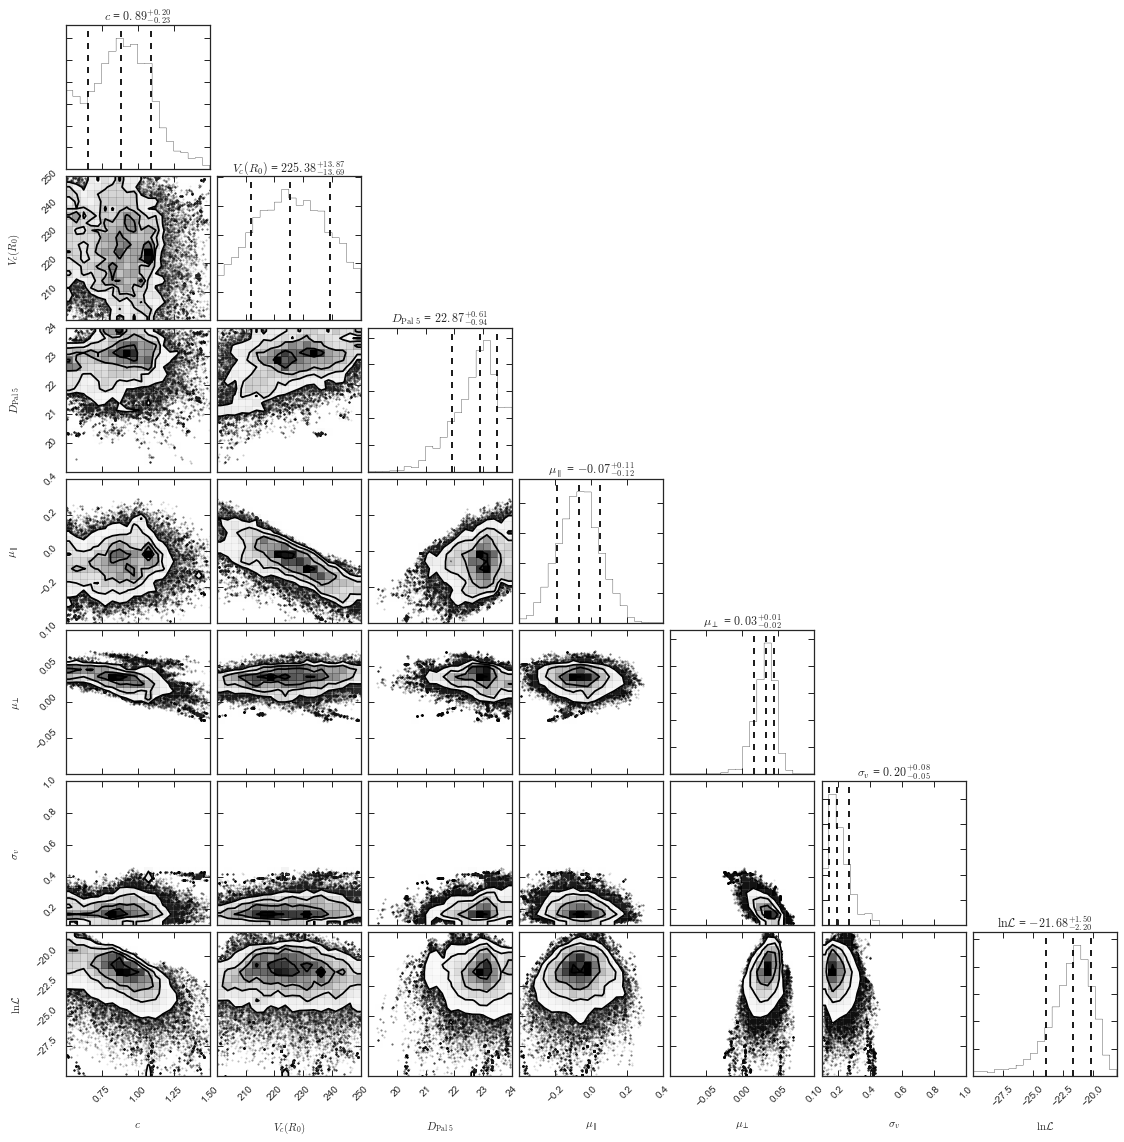

In [15]:
data,_,weights,_= read_mcmc(nburn=None,skip=1,
                            evi_func=lambda x: 1.)
plot_corner(data,weights=weights)

In [39]:
savefilename= 'pal5_forces_mcmc.pkl'
if not os.path.exists(savefilename):
    data_wf,index_wf,weights_wf,evi_wf= read_mcmc(nburn=None,addforces=True,skip=1,
                                                  evi_func=lambda x: 1.)
    save_pickles(savefilename,data_wf,index_wf,weights_wf,evi_wf)
else:
    with open(savefilename,'rb') as savefile:
        data_wf= pickle.load(savefile)
        index_wf= pickle.load(savefile)
        weights_wf= pickle.load(savefile)
        evi_wf= pickle.load(savefile)

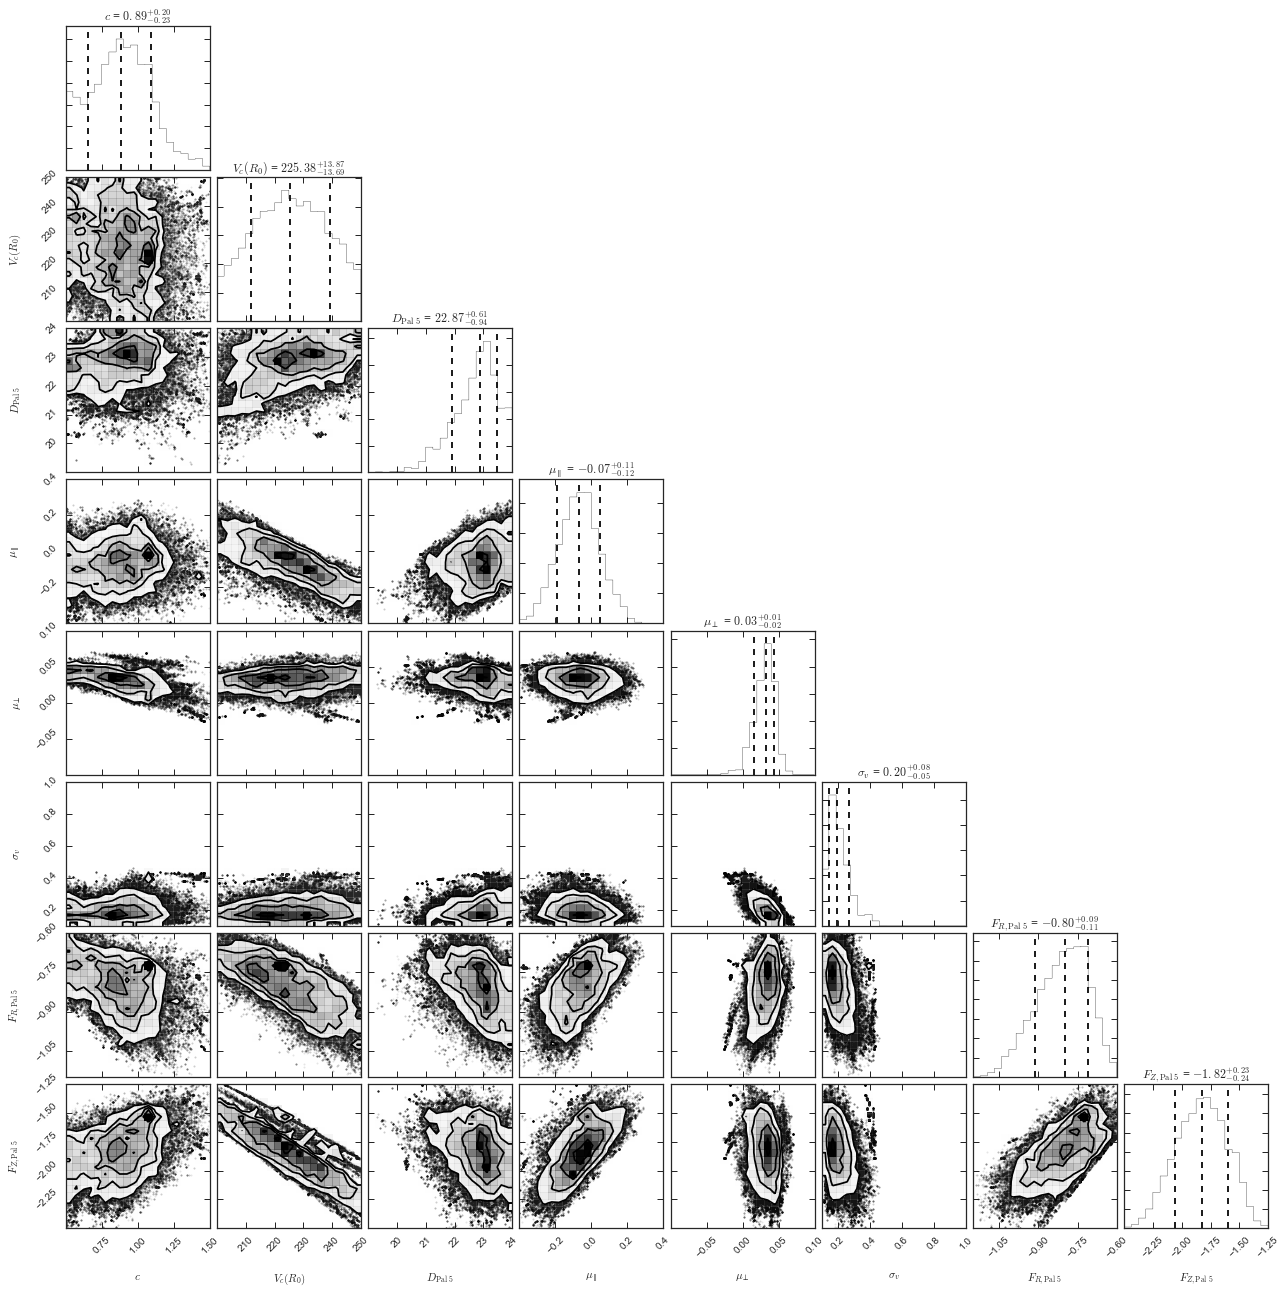

In [40]:
plot_corner(data_wf,weights=weights_wf,addvcprior=False)

The posterior PDF for the potential flattening:

0.941462735418 0.0482444490154


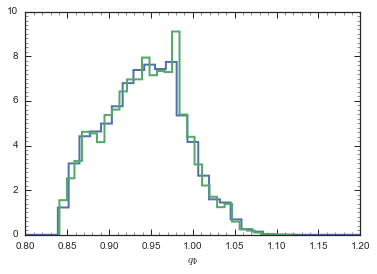

In [41]:
figsize(6,4)
bins= 31
dum= bovy_plot.bovy_hist(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1]),weights=weights_wf,
                         histtype='step',lw=2.,bins=bins,
                         xlabel=r'$q_\mathrm{\Phi}$',xrange=[0.8,1.2],normed=True)
dum= bovy_plot.bovy_hist(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1]),
                         weights=weights_wf*numpy.exp(-0.5*(data_wf[:,1]-1.)**2./(10./220.)**2.),
                         bins=bins,histtype='step',lw=2.,normed=True,overplot=True)
mq= numpy.sum(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1])*weights_wf)/numpy.sum(weights_wf)
print mq, numpy.sqrt(numpy.sum((numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1])-mq)**2.*weights_wf)/numpy.sum(weights_wf))

Which potential is preferred?

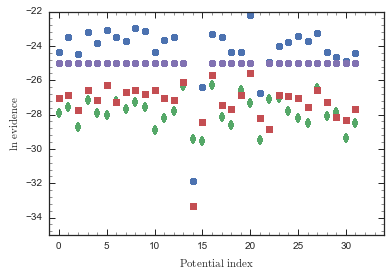

In [627]:
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=evi_harmonic)
figsize(6,4)
bovy_plot.bovy_plot(potindx,numpy.log(evidences),'o',
                    xrange=[-1,34],
                    yrange=[-35,-22],
                   xlabel=r'$\mathrm{Potential\ index}$',
                   ylabel=r'$\ln\ \mathrm{evidence}$')
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=evi_laplace)
bovy_plot.bovy_plot(potindx,numpy.log(evidences)-30.,'d',
                    overplot=True)
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=lambda x: numpy.exp(numpy.amax(x[:,-1])))
bovy_plot.bovy_plot(potindx,numpy.log(evidences)-8.,'s',
                    overplot=True)
data_noforce,potindx,weights,evidences= read_mcmc(evi_func=lambda x: numpy.exp(-25.) if (numpy.log(evi_harmonic(x)) > -25.) else numpy.exp(-50.))
bovy_plot.bovy_plot(potindx,numpy.log(evidences),'o',
                    overplot=True)

## Look at the results for individual potentials

### The flattening $c$

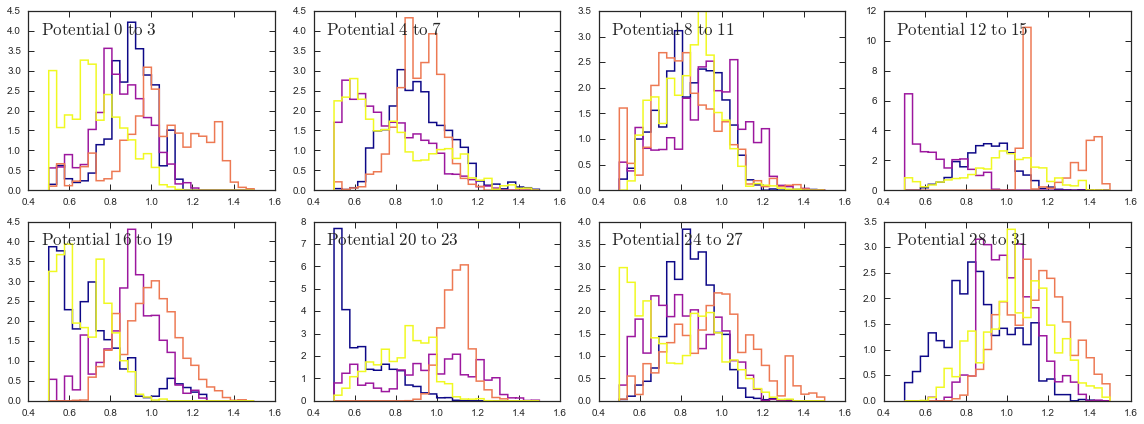

In [665]:
npot= 32
nwalkers= 12
figsize(16,6)
cmap= cm.plasma
maxl= numpy.zeros((npot,2))
for en,ii in enumerate(range(npot)):
    data_ip,_,weights_ip,evi_ip= read_mcmc(singlepot=ii,evi_func=evi_harmonic)
    try:
        maxl[en,0]= numpy.amax(data_ip[:,-1])
        maxl[en,1]= numpy.log(evi_ip[0])
    except ValueError:
        maxl[en]= -10000000.
    subplot(2,4,en//4+1)
    bovy_plot.bovy_hist(data_ip[:,0],range=[0.5,2.],bins=26,
                        histtype='step',color=cmap((en%4)/3.),
                        normed=True,xlabel=r'$c$',lw=1.5,
                        overplot=True)
    if en%4 == 0:
        bovy_plot.bovy_text(r'$\mathrm{Potential\ %i\ to\ % i}$' % (en,en+3),size=17.,
                            top_left=True)
tight_layout()

## What is the effective prior in $(F_R,F_Z)$?

In [42]:
frfzprior_savefilename= 'frfzprior.pkl'
if not os.path.exists(frfzprior_savefilename):
    # Compute for each potential separately
    nvoc= 10000
    ro= 8.
    npot= 32
    fs= numpy.zeros((2,nvoc,npot))
    for en,ii in tqdm.tqdm(enumerate(range(npot))):
        fn= '../pal5_mcmc/mwpot14-fitsigma-%i.dat' % ii
        # Read the potential parameters
        with open(fn,'rb') as savefile:
            line1= savefile.readline()
        potparams= [float(s) for s in (line1.split(':')[1].split(','))]
        for jj in range(nvoc):
            c= numpy.random.uniform()*1.5+0.5
            tvo= numpy.random.uniform()*50.+200.
            pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,ro,tvo)
            fs[:,jj,ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))[:2]
    save_pickles(frfzprior_savefilename,fs)
else:
    with open(frfzprior_savefilename,'rb') as savefile:
        fs= pickle.load(savefile)

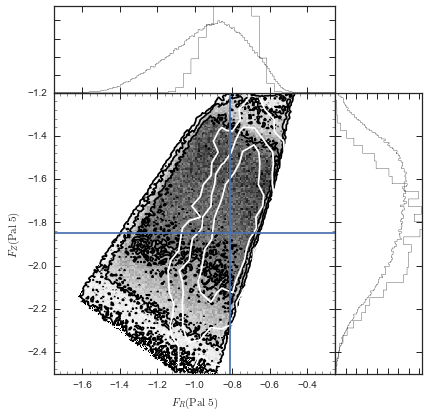

In [617]:
figsize(6,6)
bovy_plot.scatterplot(fs[0].flatten(),
                      fs[1].flatten(),
                      'k,',
                      xrange=[-1.75,-0.25],
                      yrange=[-2.5,-1.2],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                      ylabel=r'$F_Z(\mathrm{Pal\ 5})$',
                     onedhists=True)
bovy_plot.scatterplot(data_wf[:,7],data_wf[:,8],
                      weights=weights_wf,bins=26,
                      xrange=[-1.75,-0.25],
                      yrange=[-2.5,-1.2],
                      justcontours=True,
                      cntrcolors='w',
                      overplot=True,
                      onedhists=True)
pyplot.axvline(-0.81,color=sns.color_palette()[0])
pyplot.axhline(-1.85,color=sns.color_palette()[0])

The ratio of the posterior and the prior:

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):

0.937614461877


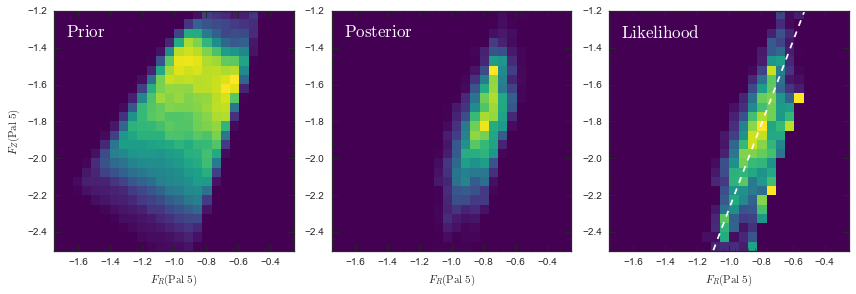

In [43]:
figsize(12,4)
bins= 26
trange= [[-1.75,-0.25],[-2.5,-1.2]]
tw= copy.deepcopy(weights_wf)
#tw[index_wf == 20]= 0.
H_prior, xedges, yedges= numpy.histogram2d(fs[0].flatten(),fs[1].flatten(),bins=bins,range=trange,normed=True)
H_post, xedges, yedges= numpy.histogram2d(data_wf[:,7],data_wf[:,8],weights=tw,
                                          bins=bins,range=trange,normed=True)
H_like= (H_post/H_prior)
H_like[H_prior == 0.]= 0.
subplot(1,3,1)
bovy_plot.bovy_dens2d(H_prior.T,origin='lower',cmap='viridis',
                      interpolation='nearest',
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                      ylabel=r'$F_Z(\mathrm{Pal\ 5})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathrm{Prior}$',top_left=True,size=17.,color='w')
subplot(1,3,2)
bovy_plot.bovy_dens2d(H_post.T,origin='lower',cmap='viridis',
                      interpolation='nearest',
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathrm{Posterior}$',top_left=True,size=17.,color='w')
subplot(1,3,3)
bovy_plot.bovy_dens2d(H_like.T,origin='lower',cmap='viridis',
                      interpolation='nearest',vmin=0.1,vmax=4.,
                      xrange=[xedges[0],xedges[-1]],
                      yrange=[yedges[0],yedges[-1]],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                      gcf=True)
bovy_plot.bovy_text(r'$\mathrm{Likelihood}$',top_left=True,size=17.,color='w')
def qline(FR,q=0.95):
    return 2.*FR/q**2.
q= numpy.sqrt(2.*0.8/1.82)
plot([-1.25,-0.2],[qline(-1.25,q=q),qline(-0.2,q=q)],'w--')
print q
tight_layout()

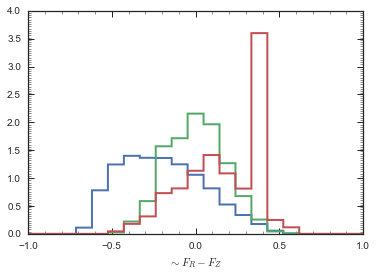

In [45]:
frs= numpy.tile(0.5*(xedges[:-1]+xedges[1:]),(len(yedges)-1,1)).T
fzs= numpy.tile(0.5*(yedges[:-1]+yedges[1:]),(len(xedges)-1,1))
figsize(6,4)
minus= -1.
if minus == 1.:
    xlabel= r'$\sim F_R+F_Z$'
else:
    xlabel= r'$\sim F_R-F_Z$'
dum= bovy_plot.bovy_hist(((frs+0.8)+minus*(fzs+1.82)).flatten(),
                         weights=H_prior.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[-1.,1.],xlabel=xlabel,normed=True)
dum= bovy_plot.bovy_hist(((frs+0.8)+minus*(fzs+1.82)).flatten(),
                         weights=H_post.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.,1.],normed=True)
dum= bovy_plot.bovy_hist(((frs+0.8)+minus*(fzs+1.82)).flatten(),
                         weights=H_like.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.,1.],normed=True)

-0.166905914139 0.317722134951


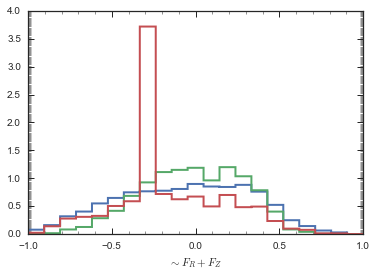

In [46]:
frs= numpy.tile(0.5*(xedges[:-1]+xedges[1:]),(len(yedges)-1,1)).T
fzs= numpy.tile(0.5*(yedges[:-1]+yedges[1:]),(len(xedges)-1,1))
figsize(6,4)
minus= 1.
if minus == 1.:
    xlabel= r'$\sim F_R+F_Z$'
else:
    xlabel= r'$\sim F_R-F_Z$'
dum= bovy_plot.bovy_hist(((frs+0.8)+minus*(fzs+1.82)).flatten(),
                         weights=H_prior.flatten(),
                         bins=21,histtype='step',lw=2.,
                         xrange=[-1.,1.],xlabel=xlabel,normed=True)
dum= bovy_plot.bovy_hist(((frs+0.8)+minus*(fzs+1.82)).flatten(),
                         weights=H_post.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.,1.],normed=True)
dum= bovy_plot.bovy_hist(((frs+0.8)+minus*(fzs+1.82)).flatten(),
                         weights=H_like.flatten(),
                         bins=21,histtype='step',lw=2.,overplot=True,
                         xrange=[-1.,1.],normed=True)
mq= (numpy.sum(((frs+0.8)+minus*(fzs+1.82)).flatten()*H_like.flatten()))/numpy.sum(H_like.flatten())
print mq, numpy.sqrt((numpy.sum((((frs+0.8)+minus*(fzs+1.82)).flatten()-mq)**2.*H_like.flatten()))/numpy.sum(H_like.flatten()))

Thus, there is only a weak constraint on $F_R+F_Z$.

/Users/bovy/Repos/galpy/galpy/util/bovy_plot.py:994: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if not weights == None:



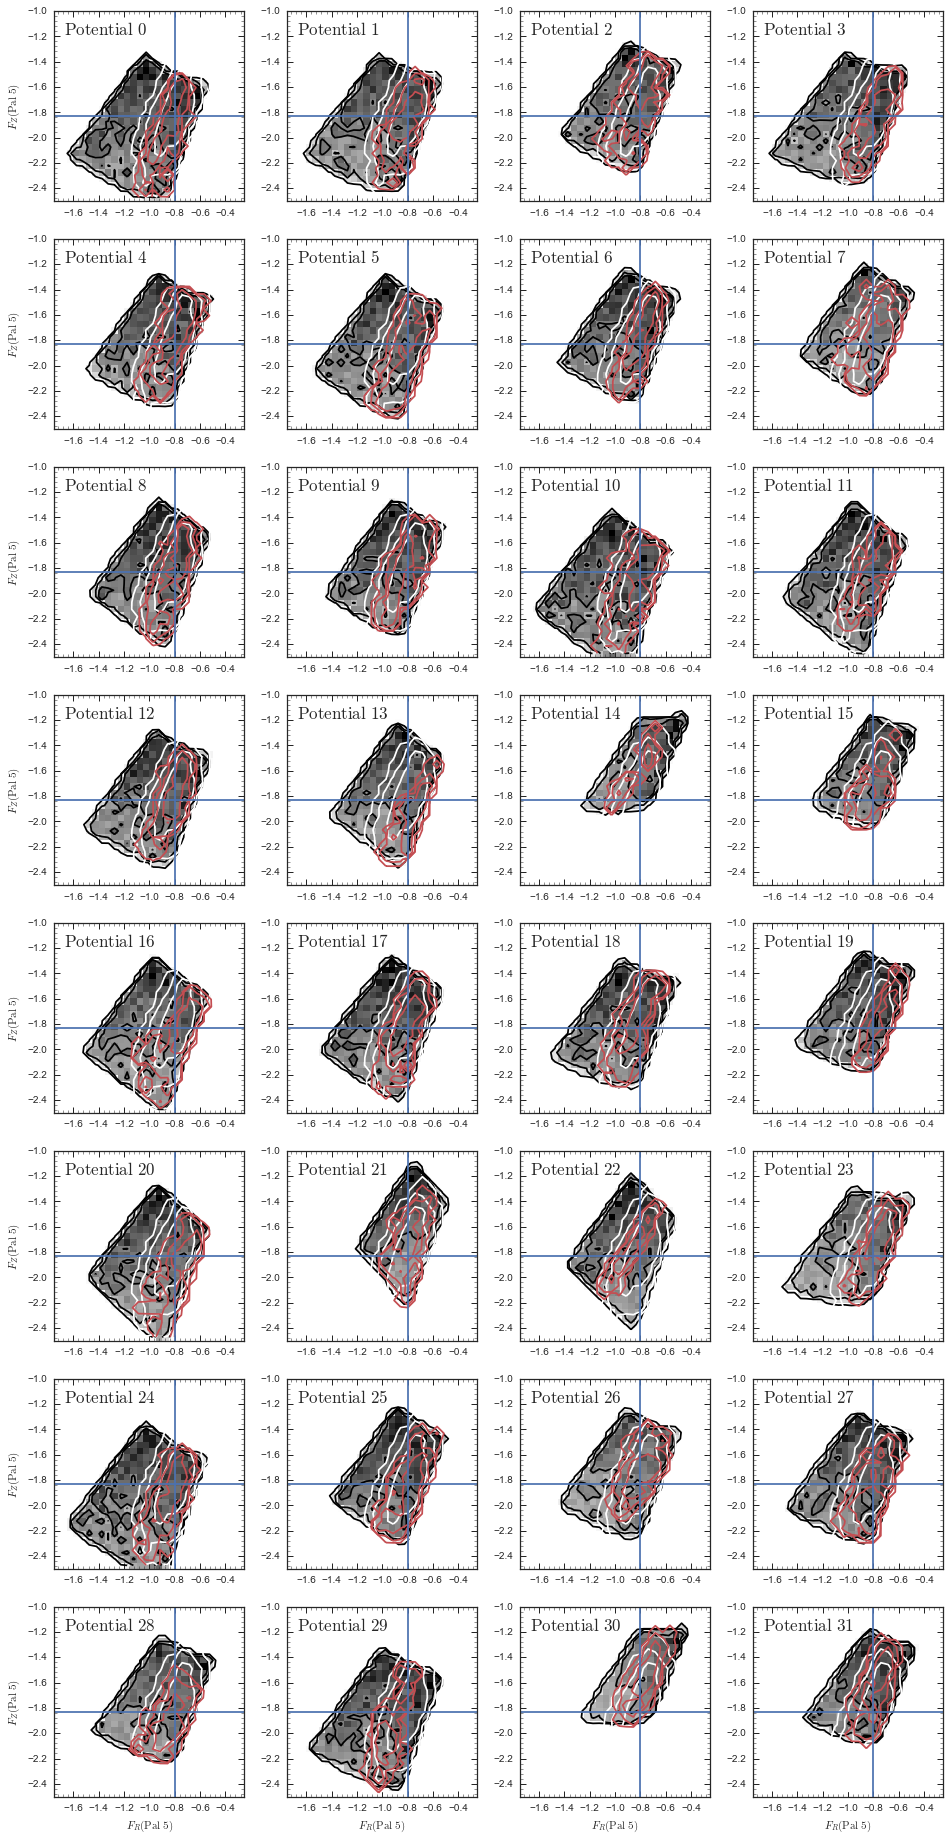

In [65]:
nrow= int(numpy.ceil(npot/4.))
figsize(16,nrow*4)
for en,ii in enumerate(range(npot)):
    subplot(nrow,4,en+1)
    if ii%4 == 0:
        ylabel=r'$F_Z(\mathrm{Pal\ 5})$'
    else:
        ylabel= None
    if ii//4 == nrow-1:
        xlabel= r'$F_R(\mathrm{Pal\ 5})$'
    else:
        xlabel= None
    bovy_plot.scatterplot(fs[0][:,en],fs[1][:,en],
                          'k,',
                          xrange=[-1.75,-0.25],
                          yrange=[-2.5,-1.],
                          xlabel=xlabel,
                          ylabel=ylabel,
                          gcf=True)
    bovy_plot.scatterplot(data_wf[:,7],data_wf[:,8],
                      weights=weights_wf,bins=26,
                      xrange=[-1.75,-0.25],
                      yrange=[-2.5,-1.],
                      justcontours=True,
                      cntrcolors='w',
                      overplot=True)
    bovy_plot.scatterplot(data_wf[index_wf == ii,7],
                          data_wf[index_wf == ii,8],
                          weights=weights_wf[index_wf == ii],
                          bins=26,
                          xrange=[-1.75,-0.25],
                          yrange=[-2.5,-1.],
                          justcontours=True,
                          cntrcolors=sns.color_palette()[2],
                          overplot=True)
    pyplot.axvline(-0.80,color=sns.color_palette()[0])
    pyplot.axhline(-1.83,color=sns.color_palette()[0])
    bovy_plot.bovy_text(r'$\mathrm{Potential}\ %i$' % ii,size=17.,
                        top_left=True)

### What about $q_\Phi$?

From posterior samples: q = 0.941 +/- 0.048
From likelihood of samples: q = 0.935 +/- 0.053


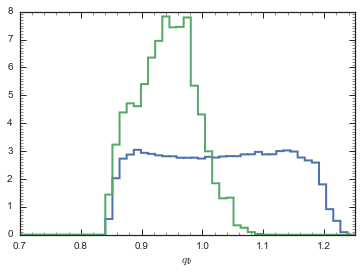

In [64]:
bins= 47
figsize(6,4)
dum= bovy_plot.bovy_hist(numpy.sqrt(2.*fs[0].flatten()/fs[1].flatten()),
                         histtype='step',lw=2.,bins=bins,
                         xlabel=r'$q_\mathrm{\Phi}$',xrange=[0.7,1.25],normed=True)
dum= bovy_plot.bovy_hist(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1]),weights=weights_wf,
                         histtype='step',lw=2.,bins=bins,
                         overplot=True,xrange=[0.7,1.25],normed=True)
mq= numpy.sum(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1])*weights_wf)/numpy.sum(weights_wf)
sq= numpy.sqrt(numpy.sum((numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1])-mq)**2.*weights_wf)/numpy.sum(weights_wf))
print "From posterior samples: q = %.3f +/- %.3f" % (mq,sq)
Hq_post, xedges= numpy.histogram(numpy.sqrt(16.8/8.4*data_wf[:,-2]/data_wf[:,-1]),
                                 weights=weights_wf,
                                 bins=bins,range=[0.7,1.25],normed=True)
Hq_prior, xedges= numpy.histogram(numpy.sqrt(2.*fs[0].flatten()/fs[1].flatten()),
                                 bins=bins,range=[0.7,1.25],normed=True)
qs= 0.5*(xedges[:-1]+xedges[1:])
Hq_like= Hq_post/Hq_prior
Hq_like[Hq_post == 0.]= 0.
mq= numpy.sum(qs*Hq_like)/numpy.sum(Hq_like)
sq= numpy.sqrt(numpy.sum((qs-mq)**2.*Hq_like)/numpy.sum(Hq_like))
print "From likelihood of samples: q = %.3f +/- %.3f" % (mq,sq)

It appears that $q_\Phi$ is the quantity that is the most strongly constrained by the Pal 5 data.

### What about the Kuepper et al. (2015) result?

In [535]:
from galpy import potential
from astropy import units as u
def setup_potential_kuepper(Mhalo,a):
    """Mhalo: mass/10^12 Msun
    a: scale length in kpc,
    
    we'll take q_\Phi into account when we evaluate the potential..."""
    return [potential.HernquistPotential(amp=3.4*10.**10.*u.Msun,a=0.7*u.kpc),
            potential.MiyamotoNagaiPotential(amp=10.**11.*u.Msun,a=6.5*u.kpc,b=0.26*u.kpc),
            potential.NFWPotential(amp=Mhalo*10.**12.*u.Msun,a=a*u.kpc)]
def force_pal5_kuepper(pot,qNFW):
    FR= pot[0].Rforce(8.4*u.kpc,16.8*u.kpc)+pot[1].Rforce(8.4*u.kpc,16.8*u.kpc)+pot[2].Rforce(8.4*u.kpc,16.8*u.kpc/qNFW)
    FZ= pot[0].zforce(8.4*u.kpc,16.8*u.kpc)+pot[1].zforce(8.4*u.kpc,16.8*u.kpc)+pot[2].zforce(8.4*u.kpc,16.8*u.kpc/qNFW)
    return (FR,FZ)

Can we recover the Kuepper et al. (2015) result as prior + $q_\Phi = 0.94 \pm 0.05$ + $V_c(R_0)$ between 200 and 280 km/s? For simplicity we will not vary $R_0$, which should not have a big impact.

In [536]:
import bovy_mcmc
import corner
def kuepper_flattening_post(params,qmean,qerr):
    """A Kuepper et al.-like posterior that consists solely of the priors and a constraint on q_\Phi"""
    Mhalo= params[0]
    a= params[1]
    qNFW= params[2]
    if Mhalo < 0.001 or Mhalo > 10.: return -1000000000000000000.
    elif a < 0.1 or a > 100.: return -1000000000000000000.
    elif qNFW < 0.2 or qNFW > 1.8: return -1000000000000000000.
    pot= setup_potential_kuepper(Mhalo,a)
    vcpred= potential.vcirc(pot,8.*u.kpc)
    if vcpred < 200. or vcpred > 280.: return -1000000000000000000.
    FR,FZ= force_pal5_kuepper(pot,qNFW)
    qpred= numpy.sqrt(2.*FR/FZ)
    return -0.5*(qpred-qmean)**2./qerr**2.
def kuepper_flatteningforce_post(params,qmean,qerr,frfz,frfzerr):
    """A Kuepper et al.-like posterior that consists solely of the priors, a constraint on q_\Phi, and a constraint
    on FR+FZ"""
    Mhalo= params[0]
    a= params[1]
    qNFW= params[2]
    if Mhalo < 0.001 or Mhalo > 10.: return -1000000000000000000.
    elif a < 0.1 or a > 100.: return -1000000000000000000.
    elif qNFW < 0.2 or qNFW > 1.8: return -1000000000000000000.
    pot= setup_potential_kuepper(Mhalo,a)
    vcpred= potential.vcirc(pot,8.*u.kpc)
    if vcpred < 200. or vcpred > 280.: return -1000000000000000000.
    FR,FZ= force_pal5_kuepper(pot,qNFW)
    qpred= numpy.sqrt(2.*FR/FZ)
    frfzpred= (FR+0.8)+(FZ+1.83)
    return -0.5*(qpred-qmean)**2./qerr**2.-0.5*(frfz-frfzpred)**2./frfzerr**2.
def sample_kuepper_flattening_post(nsamples,qmean,qerr):
    params= [1.58,37.9,0.95]
    funcargs= (qmean,qerr)
    samples=\
        bovy_mcmc.markovpy(params,0.2,
                           lambda x: kuepper_flattening_post(x,*funcargs),(),
                           isDomainFinite=[[False,False] for ii in range(len(params))],
                           domain= [[0.,0.] for ii in range(len(params))],
                           nsamples=nsamples,
                           nwalkers=2*len(params))
    samples= numpy.array(samples).T
    return samples
def sample_kuepper_flatteningforce_post(nsamples,qmean,qerr,frfz,frfzerr):
    params= [1.58,37.9,0.95]
    funcargs= (qmean,qerr,frfz,frfzerr)
    samples=\
        bovy_mcmc.markovpy(params,0.2,
                           lambda x: kuepper_flatteningforce_post(x,*funcargs),(),
                           isDomainFinite=[[False,False] for ii in range(len(params))],
                           domain= [[0.,0.] for ii in range(len(params))],
                           nsamples=nsamples,
                           nwalkers=2*len(params))
    samples= numpy.array(samples).T
    return samples
def plot_kuepper_samples(samples):
    labels= [r'$M_{\mathrm{halo}} / (10^{12}\,M_\odot)$',
             r'$q_z$',r'$a / \mathrm{kpc}$']
    ranges= [(0.,4.),(0.2,1.8),(0.,100.)]
    corner.corner(samples[[0,2,1]].T,quantiles=[0.16, 0.5, 0.84],labels=labels,
                  show_titles=True, title_args={"fontsize": 12},range=ranges)

In [509]:
s= sample_kuepper_flattening_post(50000,0.94,0.05)

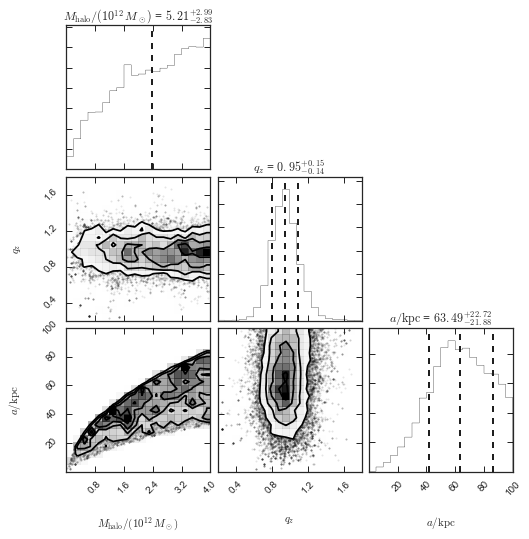

In [523]:
plot_kuepper_samples(s)

The constraint on the potential flattening gets you far, but there is more going on (the constraint on the halo mass and scale parameter appear to come completely from the $V_c(R_0)$ constraint). Let's add the weak constraint on the sum of the forces, scaled to Kuepper et al.'s best-fit acceleration (which is higher than ours):

In [573]:
s= sample_kuepper_flatteningforce_post(50000,0.94,0.05,-0.83,0.36)

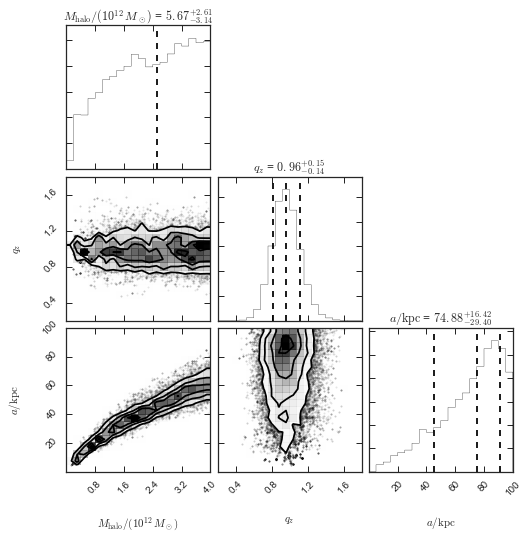

In [574]:
plot_kuepper_samples(s)

This gets a tight relation between $M_\mathrm{halo}$ and the scale parameter of the halo, but does not lead to a constraint on either independently; the halo potential flattening constraint is that of Kuepper et al. Based on this, it appears that the information that ties down $M_\mathrm{halo}$ comes from the overdensities, which may be spurious (Thomas et al. 2016) and whose use in dynamical modeling is dubious anyway. 

What is Kuepper et al.'s prior on $a_{\mathrm{Pal\ 5}}$?

In [580]:
apal5s= []
ns= 100000
for ii in range(ns):
    Mh= numpy.random.uniform()*(10.-0.001)+0.001
    a= numpy.random.uniform()*(100.-0.1)+0.1
    q= numpy.random.uniform()*(1.8-0.2)+0.2
    pot= setup_potential_kuepper(Mh,a)
    FR,FZ= force_pal5_kuepper(pot,q)
    apal5s.append(numpy.sqrt(FR**2.+FZ**2.))
apal5s= numpy.array(apal5s)

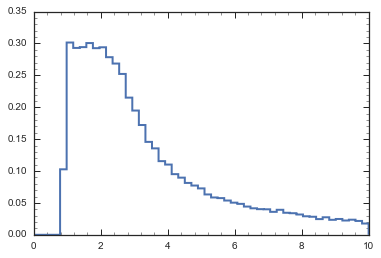

In [581]:
figsize(6,4)
dum= bovy_plot.bovy_hist(apal5s,range=[0.,10.],
                         lw=2.,bins=51,
                        histtype='step',normed=True)

This prior is clearly non-flat, and has a very long tail toward higher accelerations that may be biasing their inferred acceleration high.